In [57]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load data from CSV
data = pd.read_csv('./PEM.csv')

# Normalize data if necessary
normalized_data = (data[['from', 'to', 'cost', 'distance']] - data[['from', 'to', 'cost', 'distance']].min()) / \
                  (data[['from', 'to', 'cost', 'distance']].max() - data[['from', 'to', 'cost', 'distance']].min())

# Define the GAN architecture
latent_dim = 100

# Generator model
generator = keras.Sequential([
    layers.Dense(128, activation='relu', input_dim=latent_dim),
    layers.Dense(4, activation='sigmoid')
])

# Discriminator model
discriminator = keras.Sequential([
    layers.Dense(128, activation='relu', input_dim=4),
    layers.Dense(1, activation='sigmoid')
])

# Compile the discriminator
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

# GAN model
discriminator.trainable = False  # Set discriminator as non-trainable in GAN
gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Train the GAN
epochs = 1000
batch_size = 16

for epoch in range(epochs):
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    generated_data = generator.predict(noise)

    # Train discriminator on real data
    real_data = normalized_data.sample(batch_size)
    real_labels = np.ones((batch_size, 1))
    discriminator.train_on_batch(real_data, real_labels)

    # Train discriminator on generated data
    generated_labels = np.zeros((batch_size, 1))
    discriminator.train_on_batch(generated_data, generated_labels)

    # Train generator via GAN
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    gan.train_on_batch(noise, np.ones((batch_size, 1)))

# Anomaly Detection
generated_samples = generator.predict(np.random.normal(0, 1, size=[100, latent_dim]))
anomaly_scores = discriminator.predict(generated_samples)

# Identify anomalies
anomalies_indices = np.where(anomaly_scores > 0.5)[0]
anomalies = data.iloc[anomalies_indices]

print("Detected anomalies:", anomalies)


4/4 [==============================] - 0s 483us/step
Detected anomalies:     from   to   cost  distance
0    721  445  0.790       276
3     32  266  0.596       234
4     34   56  0.628        22
8    449  555  3.909       106
9    871  763  1.134       108
..   ...  ...    ...       ...
91    58  564  0.750       506
92   325  610  1.046       285
95   118  472  0.805       354
98    99  287  1.310       188
99   287  672  1.125       385

[63 rows x 4 columns]


In [58]:
anomalies.to_csv('anomalies.csv', index=False)

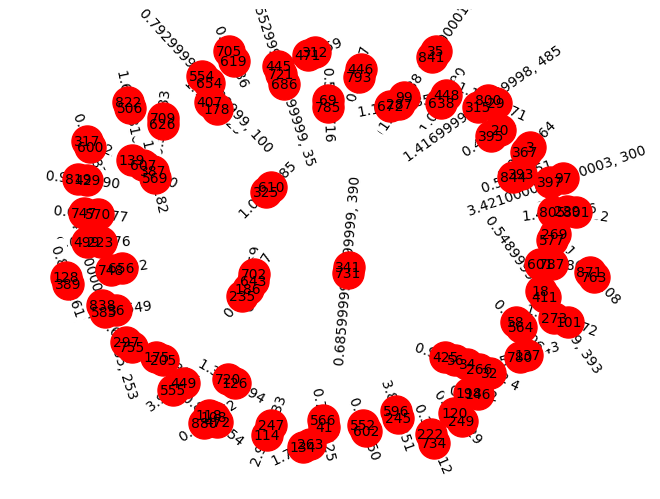

<Figure size 4000x3000 with 0 Axes>

In [63]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.from_pandas_edgelist(anomalies, 'from', 'to', edge_attr=['cost', 'distance'])

# Visualize only the anomalies
pos = nx.spring_layout(G)  # Layout for the nodes
nx.draw(G, pos, with_labels=True, edge_color='red', node_color='red', node_size=500, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d["cost"]}, {d["distance"]}' for u, v, d in G.edges(data=True)})

plt.figure(figsize=(40, 30))
plt.show()